# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук - fork от Baseline*   


## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [ ]:
!pip install -q tensorflow==2.3

     |████████████████████████████████| 320.4MB 40kB/s 
     |████████████████████████████████| 460kB 27.5MB/s 
     |████████████████████████████████| 2.9MB 8.7MB/s 
     |████████████████████████████████| 20.1MB 86.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [3]:
#аугментации изображений
!pip install albumentations -q

     |████████████████████████████████| 631 kB 9.2 MB/s 


In [22]:
!pip install catboost

     |████████████████████████████████| 69.2MB 47kB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5
Tensorflow   : 2.5.0


In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -l "/content/drive/MyDrive/Colab Notebooks/img" | wc -l


9091


# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [7]:
DATA_DIR_KAGGLE = '../input/sf-dst-car-price-prediction-part2/'
DATA_DIR_COLAB = '/content/drive/MyDrive/Colab Notebooks/'

DATA_DIR = DATA_DIR_COLAB

train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [8]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [8]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, 
                                         shuffle=True, 
                                         random_state=RANDOM_SEED)

In [9]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: \
{(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

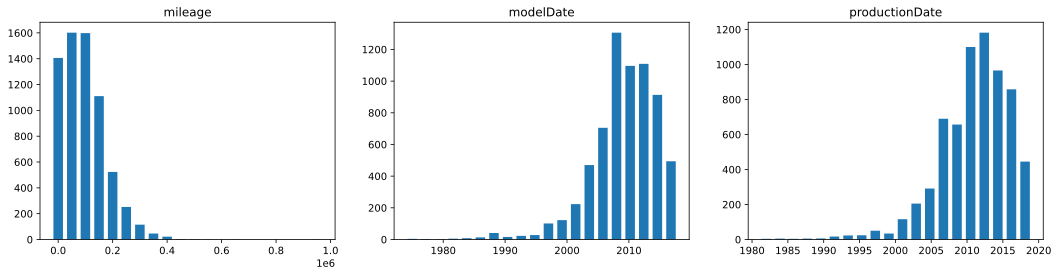

In [10]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [11]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'Владельцы', 
                        'fuelType', 'model_info', 'name', 'Владение',
                        'numberOfDoors', 'vehicleTransmission', 
                        'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 
                      # 'productionDate', 
                      'engineDisplacement', 'enginePower',
                      'yearsOld', 'years_per_owner', 'years_owned']

In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать,
                  # поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [13]:
def years_owned_f(s, correct_val):
    if str(s)=='nan':
        return correct_val
    nwords = len(s.split())
    if nwords>2:
        return int(s.split()[0])
    if 'ме' in s:
        return 0
    return int(s.split()[0])

In [14]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)



    # ################### Обработка NAN ############################################################## 

    df_output.Владельцы.fillna('1 владелец', inplace=True)


    # ################### Дотачивание до нужных типов ############################################################## 

    df_output.engineDisplacement = df_output.engineDisplacement.apply(lambda x: '0.0 LTR' if 'undefined' in x else x)
    df_output.engineDisplacement = df_output.engineDisplacement.str.split().str[0].astype('float64')

    df_output.Владельцы = df_output.Владельцы.str.split().str[0].astype('int64')

    df_output.enginePower = df_output.enginePower.str.replace(' N12', '')
    df_output.enginePower = df_output.enginePower.apply(lambda x: int(x))

    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    df_output['yearsOld'] = datetime.now().year - df_output.productionDate
    df_output['years_per_owner'] = round(df_output['yearsOld'] / df_output['Владельцы'],0).astype('int64')
    df_output['years_owned'] = df_output.apply(lambda x: years_owned_f(x['Владение'], x.years_per_owner), axis=1).astype('int64')


    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    for column in numerical_features:
      df_output[column] = df_output[column].apply(lambda x: np.log1p(x))

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    # df_output.drop(['Владение'], axis = 1, inplace=True)
    df_output.drop(['productionDate'], axis = 1, inplace=True)
    
    return df_output

In [15]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

engineDisplacement  enginePower   mileage  ...  Привод_2  Руль_0  Руль_1
7399            0.541682     0.528676  0.829686  ...         1       1       0
4273            0.541682     0.528676  0.763680  ...         1       1       0
3362            0.922912     0.919349  0.778972  ...         1       1       0
2794            0.683527     0.528676  0.841535  ...         1       1       0
5378            0.541682     0.476348  0.854919  ...         1       1       0
5902            0.793550     0.899726  0.797132  ...         1       1       0
1454            0.683527     0.648449  0.775812  ...         1       1       0
2476            0.617688     0.476348  0.866520  ...         0       1       0
743             0.471125     0.190324  0.838424  ...         0       1       0
1168            0.922912     0.886702  0.746676  ...         1       1       0

[10 rows x 1346 columns]

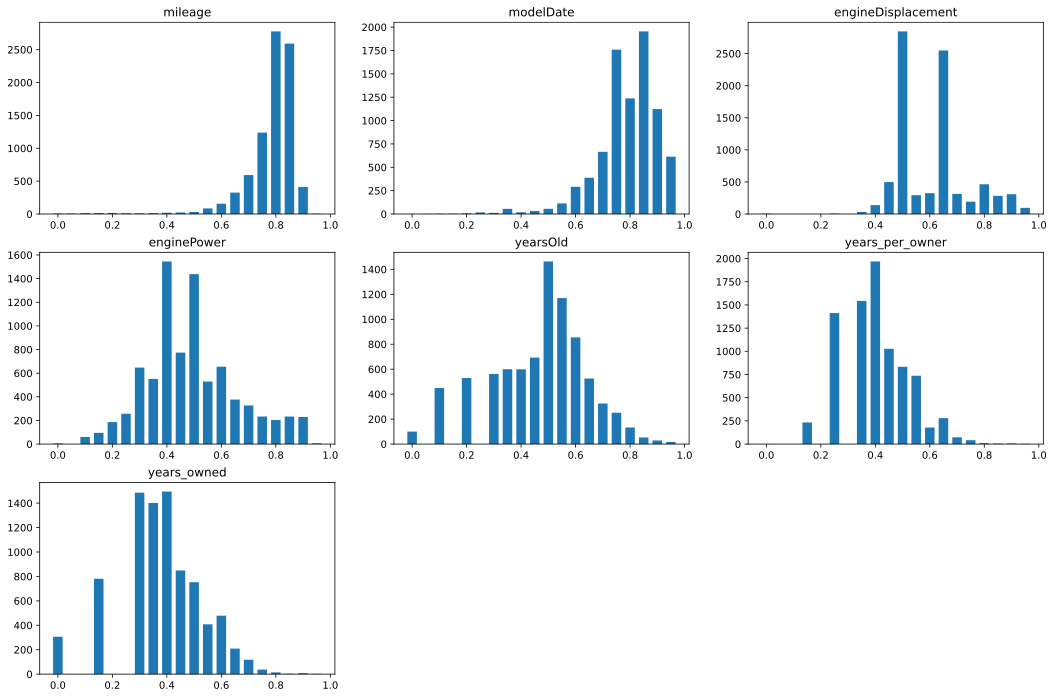

In [16]:
numeric_categories_dict_to_print = {}
for categ in numerical_features:
  numeric_categories_dict_to_print.update({categ: df_preproc[categ].dropna()} )

# numeric_categories_dict_to_print
visualize_distributions( numeric_categories_dict_to_print)

In [19]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 1346 entries, engineDisplacement to Руль_1
dtypes: float64(8), int64(1), uint8(1337)
memory usage: 11.2 MB


## Split data

In [17]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 1345 entries, engineDisplacement to Руль_1
dtypes: float64(8), uint8(1337)
memory usage: 2.2 MB


# Model 2: CatBoostRegressor

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [41]:
model = CatBoostRegressor(iterations = 5000,
                          # depth=10,
                          # learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          # task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.023474
0:	learn: 0.9861126	test: 1.0098104	best: 1.0098104 (0)	total: 54.4ms	remaining: 4m 31s
100:	learn: 0.3105921	test: 0.3103511	best: 0.3103511 (100)	total: 733ms	remaining: 35.5s
200:	learn: 0.2439451	test: 0.2423470	best: 0.2423470 (200)	total: 1.42s	remaining: 33.8s
300:	learn: 0.2050939	test: 0.2042027	best: 0.2042027 (300)	total: 2.12s	remaining: 33s
400:	learn: 0.1893538	test: 0.1894200	best: 0.1894200 (400)	total: 2.78s	remaining: 31.9s
500:	learn: 0.1795954	test: 0.1812613	best: 0.1812613 (500)	total: 3.51s	remaining: 31.6s
600:	learn: 0.1717277	test: 0.1738846	best: 0.1738846 (600)	total: 4.21s	remaining: 30.8s
700:	learn: 0.1637340	test: 0.1670391	best: 0.1670391 (700)	total: 4.91s	remaining: 30.1s
800:	learn: 0.1586819	test: 0.1626536	best: 0.1626536 (800)	total: 5.6s	remaining: 29.3s
900:	learn: 0.1548084	test: 0.1590110	best: 0.1590110 (900)	total: 6.36s	remaining: 28.9s
1000:	learn: 0.1509510	test: 0.1557132	best: 0.1557127 (999)	total: 7.12s	r

результат работы :

bestTest = 0.1247869391
bestIteration = 4982

Shrink model to first 4983 iterations.
<catboost.core.CatBoostRegressor at 0x7f42bed4ca10>



In [42]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.48%


результат работы:

TEST mape: 12.48%

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [20]:
X_train.head(5)

engineDisplacement  enginePower   mileage  ...  Привод_2  Руль_0  Руль_1
7320            0.959452     0.886702  0.855429  ...         0       1       0
8037            0.541682     0.528676  0.705392  ...         1       1       0
4681            0.695702     0.546610  0.846775  ...         1       1       0
6014            0.507665     0.400411  0.915514  ...         0       1       0
3649            0.683527     0.638525  0.842142  ...         1       1       0

[5 rows x 1344 columns]

## Simple Dense NN

In [21]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               688640    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 820,225
Trainable params: 820,225
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [25]:
# checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5' , 
                             monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [27]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
12/12 [==============================] - 0s 9ms/step - loss: 11.7106 - MAPE: 11.7106 - val_loss: 13.7429 - val_MAPE: 13.7429
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 11.5790 - MAPE: 11.5790 - val_loss: 13.7184 - val_MAPE: 13.7184
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 11.5310 - MAPE: 11.5310 - val_loss: 13.7072 - val_MAPE: 13.7072
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 11.5010 - MAPE: 11.5010 - val_loss: 13.7152 - val_MAPE: 13.7152
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 11.4753 - MAPE: 11.4753 - val_loss: 13.7544 - val_MAPE: 13.7544
Epoch 6/500
12/12 [==============================] - 0s 10ms/step - loss: 11.5956 - MAPE: 11.5956 - val_loss: 13.7218 - val_MAPE: 13.7218
Epoch 7/500
12/12 [==============================] - 0s 10ms/step - loss: 11.6187 - MAPE: 11.6187 - val_loss: 13.7041 - val_MAPE: 13.7041
Epoch 8/500
12/12 [================

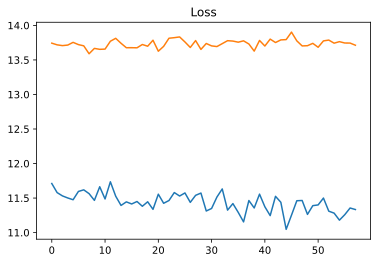

In [28]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [29]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5')
model.save('/content/drive/MyDrive/Colab Notebooks/car_predict/nn_1.hdf5')

In [30]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 13.71%


Имеем на сейчас предобработанные данные, пронормированные (лог). 

Результаты работы простой нейросети дали 

TEST mape: 13.71%

остановка была по earlyStop на первой сотне эпох

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [22]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 8.2 MB 8.5 MB/s 


In [44]:
# !pip install -U pymorphy2-dicts-ru

In [23]:
import pymorphy2

In [24]:
morph = pymorphy2.MorphAnalyzer()


In [49]:

desc0 = [morph.parse(word)[0].normal_form for word in re.findall(r'\w+', data.description[0])]

In [52]:
' '.join([morph.parse(word)[0].normal_form for word in re.findall(r'\w+', data.description[0])])

'весь привет продать эксклюзивный проект 124 универсал 300te 24 sportline модель 124 091 300 te 24 двигатель 104 980 трансмиссия 722 359 цвет кузов 040 чёрный отделка салон 271 кожа чёрный антрацит опция 211 автоматический блокировка дифференциал asd 240 индикатор внешний температура 244 спортивный сидение спереди 281 спортивный рулевой колесо с отделка из кожа диаметр 390 мм и кожаный рычаг кпп 291 подушка безопасность для водитель и передний пассажир 300 дополнительный бардачок в вещевой отсек спереди 412 люк с электропривод и устройство подъём 420 автоматический коробка передача напольный исполнение 440 темпомат круиз контроль 538 автоматический антенна 541 двойной занавеска для багажный пространство и пасажирский отсек сетка шторка 570 складный подлокотник спереди 586 кондиционер behr и электрический стеклоподъёмник передний и задний дверь 598 атермальный боковой и задний стекло задний стекло с подогрев esg 650 спортивный подвеска 673 акб увеличить мощность 812 установленный сзади 

In [25]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [54]:
resss = data.description.apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in re.findall(r'\w+', x)]))
resss

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес и тюнинг hamman ...
2       машина тут продаваться не в первый раз но толь...
3       автомобиль в отличный состояние весь в родный ...
4       немка с бесключивый доступ и камера задний вид...
                              ...                        
8348    продаваться любимый автомобиль за год эксплуат...
8349    купить у официальный дилер в 2017 г третий вла...
8350    торг на место всё работать сборка немецкий рез...
8351    автомобиль в отличный состояние 3 из авто в се...
8352    удлинённый заводский pullman на база w140 вооб...
Name: description, Length: 8353, dtype: object

In [55]:
resss.to_csv('/content/drive/MyDrive/Colab Notebooks/car_predict/desc_lemmatized.csv')

In [26]:
desc_lemmatized = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car_predict/desc_lemmatized.csv')
desc_lemmatized.description

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес и тюнинг hamman ...
2       машина тут продаваться не в первый раз но толь...
3       автомобиль в отличный состояние весь в родный ...
4       немка с бесключивый доступ и камера задний вид...
                              ...                        
8348    продаваться любимый автомобиль за год эксплуат...
8349    купить у официальный дилер в 2017 г третий вла...
8350    торг на место всё работать сборка немецкий рез...
8351    автомобиль в отличный состояние 3 из авто в се...
8352    удлинённый заводский pullman на база w140 вооб...
Name: description, Length: 8353, dtype: object

In [28]:
data.description = desc_lemmatized.description.astype(str)

In [29]:
data.description

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес и тюнинг hamman ...
2       машина тут продаваться не в первый раз но толь...
3       автомобиль в отличный состояние весь в родный ...
4       немка с бесключивый доступ и камера задний вид...
                              ...                        
8348    продаваться любимый автомобиль за год эксплуат...
8349    купить у официальный дилер в 2017 г третий вла...
8350    торг на место всё работать сборка немецкий рез...
8351    автомобиль в отличный состояние 3 из авто в се...
8352    удлинённый заводский pullman на база w140 вооб...
Name: description, Length: 8353, dtype: object

В ходе лемматизации убрали знаки припенания, все слова перевели в "normal_form", таким образом ожидаем, что словарь при токенизации сократится.

In [30]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [31]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [33]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.46 s, sys: 9.09 ms, total: 1.47 s
Wall time: 1.47 s


In [37]:
tokenize.word_index

{'в': 1,
 'и': 2,
 'с': 3,
 'автомобиль': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'пробег': 9,
 'всё': 10,
 'задний': 11,
 'салон': 12,
 'сидение': 13,
 'состояние': 14,
 'год': 15,
 'для': 16,
 'передний': 17,
 'машина': 18,
 'от': 19,
 'до': 20,
 'при': 21,
 'диск': 22,
 'у': 23,
 '2': 24,
 'комплект': 25,
 'дилер': 26,
 'новый': 27,
 'официальный': 28,
 'без': 29,
 'ваш': 30,
 'кредит': 31,
 'вы': 32,
 'фара': 33,
 'авто': 34,
 'гарантия': 35,
 'пакет': 36,
 'руль': 37,
 'колесо': 38,
 'безопасность': 39,
 'быть': 40,
 'комплектация': 41,
 'за': 42,
 'обмен': 43,
 'птс': 44,
 'контроль': 45,
 'то': 46,
 'зеркало': 47,
 'bmw': 48,
 '000': 49,
 'проверка': 50,
 'из': 51,
 'покупка': 52,
 'весь': 53,
 'два': 54,
 'продажа': 55,
 'водитель': 56,
 'более': 57,
 'полный': 58,
 'есть': 59,
 'шина': 60,
 'датчик': 61,
 'отличный': 62,
 'пассажир': 63,
 '1': 64,
 'двигатель': 65,
 'резина': 66,
 'мы': 67,
 'условие': 68,
 'владелец': 69,
 'только': 70,
 'ключ': 71,
 'один': 72,
 'хо

In [34]:
len(tokenize.word_index)

23487

после лемматизации сократился словарь для токенизации (с 39,5 т до 23,5 т записей)

In [35]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.34 s, sys: 13.5 ms, total: 1.35 s
Wall time: 1.35 s


In [80]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить по 110 пункт автокредит по специальный ставка от 13 7 ауди центр север официальный дилер audi входящий в группа компания рольф и являться один из крупный дилер в европа предлагать вы ряд услуга по покупка и продажа автомобиль с пробег на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер audi в россия и предоставлять клиент самый большой выбор автомобиль с пробег audi и другой марка каждый автомобиль проходить тщательный диагностик и подготовка и гарантировать находиться в отличный состояние чтобы убедиться в правильный выбор у вы есть возможность пройти тест драйв ознакомительный поездка на интересовать автомобиль вы смочь ознакомиться с автомобиль не выходить из дом наш менеджер провести online презентация и в видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условие специалист компания подобрать для вы хорош

### RNN NLP

In [81]:
model_nlp = Sequential()
# model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.InputLayer(input_shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [82]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [83]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [84]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     6012928     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256, 256)     525312      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256)     0           lstm_2[0][0]                     
____________________________________________________________________________________________

### Fit

In [85]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [86]:
# checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5', 
                             monitor=['val_MAPE'], verbose=0, mode='min')

earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [87]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 14s 376ms/step - loss: 99.9866 - MAPE: 99.9866 - val_loss: 99.8382 - val_MAPE: 99.8382
Epoch 2/500
12/12 [==============================] - 4s 303ms/step - loss: 98.5578 - MAPE: 98.5578 - val_loss: 93.4542 - val_MAPE: 93.4542
Epoch 3/500
12/12 [==============================] - 4s 305ms/step - loss: 78.9766 - MAPE: 78.9766 - val_loss: 51.1413 - val_MAPE: 51.1413
Epoch 4/500
12/12 [==============================] - 4s 298ms/step - loss: 53.6203 - MAPE: 53.6203 - val_loss: 48.2222 - val_MAPE: 48.2222
Epoch 5/500
12/12 [==============================] - 4s 300ms/step - loss: 47.4697 - MAPE: 47.4697 - val_loss: 45.2948 - val_MAPE: 45.2948
Epoch 6/500
12/12 [==============================] - 4s 301ms/step - loss: 43.9828 - MAPE: 43.9828 - val_loss: 41.9029 - val_MAPE: 41.9029
Epoch 7/500
12/12 [==============================] - 4s 301ms/step - loss: 40.8102 - MAPE: 40.8102 - val_loss: 38.5477 - val_MAPE: 38.5477
Epoch 8/500
12/12 [=======

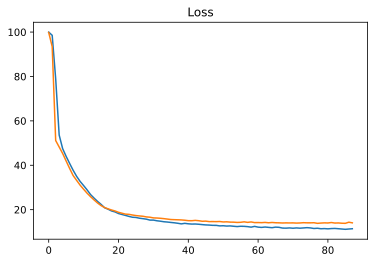

In [88]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [89]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5')
model.save('/content/drive/MyDrive/Colab Notebooks/car_predict/nn_mlp_nlp.hdf5')

In [90]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 14.05%


получили результат (который опять чуть-чуть улучшен относительно baseline)

TEST mape: 14.05%

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

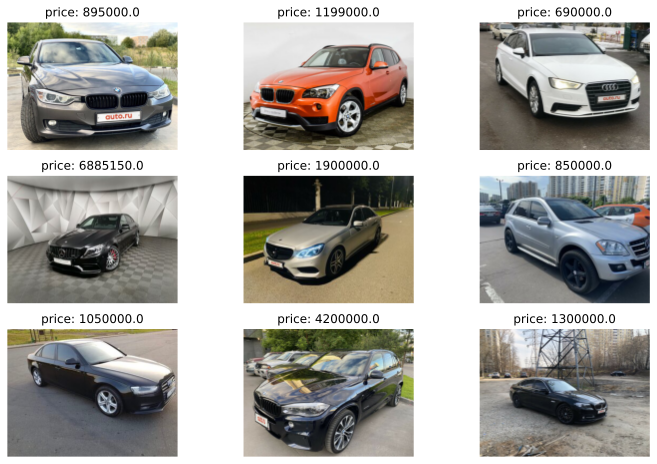

In [36]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    # im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    im = PIL.Image.open(DATA_DIR+'img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [47]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        # image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        image = cv2.imread(DATA_DIR + 'img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)ModelCheckpoint

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

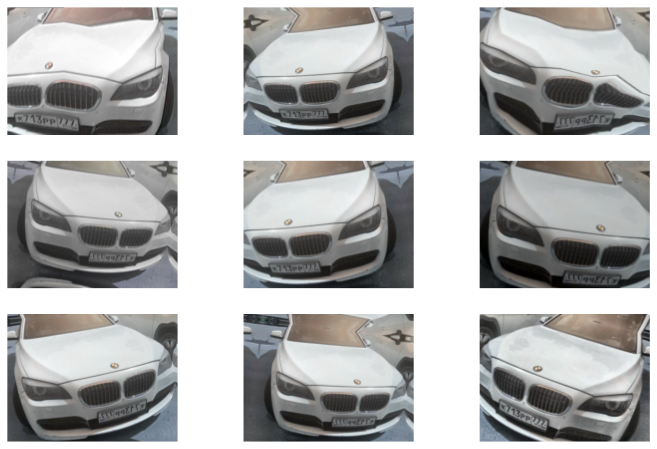

In [49]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [50]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [51]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [52]:
len(tokenize.word_index)

23487

In [53]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [39]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', 
                                                                       include_top = False, 
                                                                       input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [40]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    # L.Input(shape = X.shape[1]),
    L.InputLayer(input_shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [41]:
# NLP
nlp_model = Sequential([
    # L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.InputLayer(input_shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [42]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [43]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [56]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5', 
                             monitor=['val_MAPE'], 
                             verbose=1, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, 
                          restore_best_weights=True, verbose=1)
callbacks_list = [checkpoint, earlystop]

In [57]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 243s 1s/step - loss: 54.9182 - MAPE: 54.9182 - val_loss: 36.3172 - val_MAPE: 36.3172

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
190/190 [==============================] - 188s 982ms/step - loss: 30.5053 - MAPE: 30.5053 - val_loss: 25.2057 - val_MAPE: 25.2057

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5
Epoch 3/100
190/190 [==============================] - 188s 988ms/step - loss: 22.3067 - MAPE: 22.3067 - val_loss: 19.8179 - val_MAPE: 19.8179

Epoch 00003: saving model to /content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5
Epoch 4/100
190/190 [==============================] - 185s 972ms/step - loss: 18.8266 - MAPE: 18.8266 - val_loss: 19.3750 - val_MAPE: 19.3750

Epoch 00004: saving model to /content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5
Epoch 5/100
190/190 [==============================] - 190s 996ms/step - loss: 17.3087 - MAPE: 17.3087 - val_loss: 18.7320 - val_MAPE: 18.7320

Epoch 00005: saving model to /content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5
Epoch 6/100
190/190 [===================

In [1]:
model.save('/content/drive/MyDrive/Colab Notebooks/car_predict/nn_final_learning.hdf5')

NameError: ignored

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [44]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/car_predict/best_model.hdf5')
model.save('/content/drive/MyDrive/Colab Notebooks/car_predict/nn_final.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [54]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.64%


In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = ((test_predict_catboost + test_predict_nn3[:,0]) / 2) //1000 * 1000
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

 * эта часть кода запускалась в кагле О_о
 получили результат:

 TEST mape: 11.62%

In [ ]:
blend_sub_predict = ((sub_predict_catboost + sub_predict_nn3[:,0]) / 2) //1000 * 1000
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

**ИТОГО**

чистый сабмишн catboost с использованием округления до тысяч дал на кагле результат 13.82%

с использованием nn3 (где в нейронке были табличные данные, обработка nlp и изображения), усредненные с предсказанием от catboost и округленные до тысяч на кагде дали результат в 12.51% 

12.51% :D

# Выводы

Использованные приемы бленда, мульти-входа для nn - классные штуки, которые дают прирост качества модели, при этом временные затраты на сам просчет модели почти без изменений. Возможно картина была б другой, если попробовать для nlp BERT. Но в этой сети самым затратным была часть с картинками, и честно говоря не хватило сил и времени ее раскрутить так же качественно как в прошлом проекте. По той же приичне не опробован проброс признака - хотелось увидеть как получилось улучшить бейслайн без проброса, проброс остался у обочины.

Остались пропуски в моменте - как помочь LSTM'y при работе с токенизацией (как рассказать про словосочетания, как прочистить word_index - и КАК и ПО КАКОМУ ПРИНЦИПУ - типа: надо ли убирать "с", "в", "на", числа, убирать сразу в основных текстах или после токенизации)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [ ]:
# 